In [1]:
import torch
import psutil
import torch.nn as nn

from pathlib import Path

from minllama.llama_architecture import Decoder, Tokenizer
from minllama.fsdp import load_checkpoint
import matplotlib.pyplot as plt

In [2]:
with torch.device('meta'):
    model = Decoder(
        dim=4096,
        hidden_dim=11008,
        vocab_size=32000,
        num_layers=32,
        num_heads=32,
        max_seq_len=2048
    )
print('RAM memory used:', psutil.virtual_memory()[3] // 1024 ** 3, 'GB')
load_checkpoint(model, '/project/llama/7B')
print('RAM memory used:', psutil.virtual_memory()[3] // 1024 ** 3, 'GB')
model = model.to('cuda:0')
print('RAM memory used:', psutil.virtual_memory()[3] // 1024 ** 3, 'GB')

RAM memory used: 21 GB
RAM memory used: 33 GB
RAM memory used: 21 GB


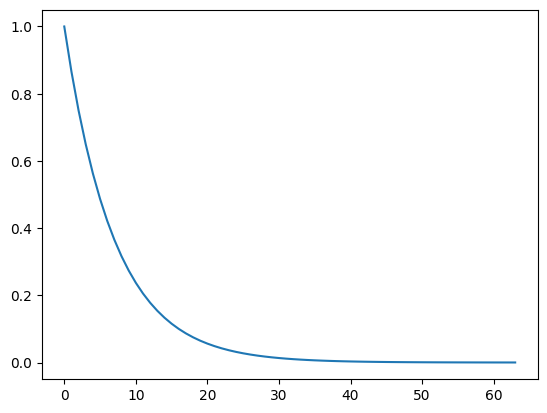

In [6]:
plt.plot(model.rope.inv_freq)

In [9]:
dim = 128
theta = 10000
freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
t = torch.arange(64, device=freqs.device)  # type: ignore
freqs = torch.outer(t, freqs).float()  # type: ignore
freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64

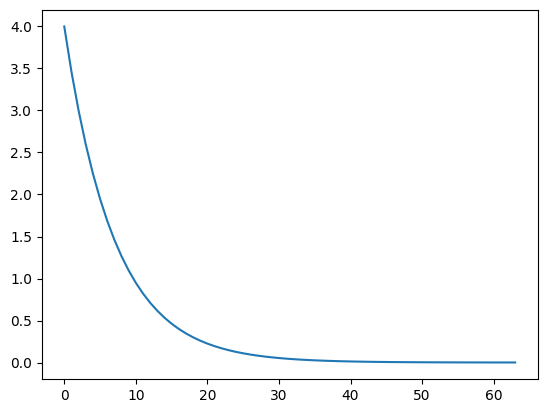

In [20]:
plt.plot(freqs[4])

In [3]:
tokenizer = Tokenizer('/project/llama/tokenizer.model')

In [4]:
x = tokenizer.encode('Hello world! My name is ', True, True)
x = torch.tensor(x).to('cuda:0')

In [5]:
output = model(x.unsqueeze(0))

In [8]:
tokenizer.decode([1, 15043,  3186, 29991,  1619,  1024,   338, 29871, 229,    2])

'Hello world! My name is �'

In [7]:
output.argmax(-1)

tensor([[  917,  6406,  8157, 30967,   374,  2341,   593,   229,     1]],
       device='cuda:0')

In [8]:
x

tensor([    1, 15043,  3186, 29991,     2], device='cuda:0')

In [50]:
from minllama.llama_architecture.rope import RoPE
from minllama.llama_architecture.rms_norm import RMSNorm
from minllama.llama_architecture.attention import Attention
from minllama.llama_architecture.feed_forward import FeedForward
from minllama.llama_architecture.llama import Decoder, DecoderLayer

import sys
sys.path.append('/workspace/test_peft/llama_facebook')
from llama.model import (
    RMSNorm as RMSNormFB,
    Attention as AttentionFB,
    FeedForward as FeedForwardFB,
    TransformerBlock as DecoderLayerFB,
    Transformer as DecoderFB,
    ModelArgs as ModelArgsFB,
    precompute_freqs_cis
)

In [48]:
batch_size = 2
seq_len = 16
dim = 1024
device = 'cuda:0'

norm_fb = RMSNormFB(dim).to(device)
norm = RMSNorm(dim).to(device)

with torch.no_grad():
    for _ in range(10):
        x = torch.rand(batch_size, seq_len, dim, device=device)
        x_fb = norm_fb(x)
        x_ours = norm(x)
        assert (x_fb - x_ours).abs().max() < 1e-8

del x, x_fb, x_ours, norm, norm_fb

In [51]:
dim = 1024
batch_size = 2
seq_len = 16
num_heads = 16
num_kv_heads = 8
device = 'cuda:0'

fb_args = ModelArgsFB(
    dim=dim,
    n_heads=num_heads,
    n_kv_heads=num_kv_heads,
    max_batch_size=batch_size,
    max_seq_len=seq_len
)

attn_fb = AttentionFB(fb_args).to(device)
attn = Attention(dim, num_heads, num_kv_heads).to(device)
freqs_cis = precompute_freqs_cis(dim // num_heads, seq_len * 2)

x = torch.rand(batch_size, seq_len, dim, device=device)
x_ours = attn(x)
x_fb = attn_fb(x, 0, freqs_cis[:seq_len])

AssertionError: model parallel group is not initialized

Load checkpoint file.

In [39]:
def get_model(device='cpu'):
    with torch.device(device):
        model = nn.Sequential(*[
            nn.Linear(16, 16, bias=False) for _ in range(3)
        ])
    return model

state_dict = get_model().state_dict()
model = get_model('meta')
key = list(state_dict.keys())[0]
model.load_state_dict({
    key: state_dict[key]
}, strict=False, assign=True)

_IncompatibleKeys(missing_keys=['1.weight', '2.weight'], unexpected_keys=[])

In [44]:
model[0].weight

Parameter containing:
tensor([[ 1.3067e-01,  1.7808e-01, -1.3912e-01,  5.9758e-02,  2.6690e-02,
          6.3502e-02, -1.2375e-01, -1.5480e-01, -1.6985e-01, -9.4968e-02,
         -6.7066e-02, -1.1284e-01, -1.0889e-01,  1.0153e-01,  1.9499e-01,
          1.8528e-01],
        [-6.3508e-02,  1.7382e-01, -2.2393e-01,  1.8159e-01, -3.5726e-02,
         -2.0888e-01, -2.1352e-01, -9.3208e-02,  1.1974e-01,  6.2761e-02,
         -9.0856e-02,  2.1681e-02, -2.2732e-02,  2.3730e-01, -1.4294e-01,
         -2.3125e-01],
        [-1.7239e-01, -1.8797e-01, -7.0783e-03,  3.6757e-02,  5.1219e-02,
          2.3199e-01, -2.4114e-01,  4.6883e-02, -2.0941e-01,  9.9014e-03,
          1.3504e-01, -2.1401e-01,  2.2762e-01,  5.0640e-02, -1.7480e-01,
          2.0185e-01],
        [ 1.5052e-01,  2.4183e-02,  2.3974e-02, -9.4944e-02, -2.0623e-01,
          1.3674e-01,  2.2247e-01, -4.3639e-02, -1.9598e-01,  1.5687e-01,
         -1.9445e-01, -1.1275e-02, -7.2789e-02, -2.2709e-01, -4.8379e-02,
         -1.0945e-01]

In [33]:
state_dict['0.weight'][0, 0] = 1.

In [34]:
model[0].weight

Parameter containing:
tensor([[-0.2451, -0.1258,  0.0406,  0.1105, -0.0436,  0.0279, -0.0516, -0.1225,
         -0.1947, -0.1041, -0.2341, -0.1972, -0.0773, -0.1696,  0.1902,  0.1106],
        [-0.1698, -0.1866,  0.0165,  0.0481,  0.1533,  0.1642,  0.1303,  0.1154,
          0.0063,  0.0223, -0.0246,  0.1763, -0.0187, -0.2442, -0.0747,  0.2332],
        [ 0.2067, -0.1883,  0.1470,  0.0086, -0.0085,  0.1871,  0.1422, -0.0079,
         -0.0829, -0.1278, -0.1966,  0.2412, -0.0578, -0.1273, -0.2231, -0.0826],
        [ 0.0279,  0.2456,  0.1913,  0.0097,  0.1439, -0.2339, -0.2466,  0.2003,
         -0.2031,  0.2219,  0.1066, -0.0086, -0.0798, -0.1804,  0.0651,  0.1439],
        [-0.1873,  0.0650, -0.0190, -0.0614, -0.1288,  0.0142, -0.1679, -0.1777,
          0.0405,  0.1557, -0.0277,  0.1315, -0.0612,  0.0685, -0.0870, -0.0893],
        [ 0.1145, -0.0235,  0.0091, -0.2238,  0.0726, -0.1341,  0.0804,  0.1073,
         -0.0766, -0.0317,  0.2395, -0.0036,  0.0099,  0.0877,  0.1088, -0.0348],


In [26]:
model[0].weight - state_dict['0.weight']

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0